# MSA Data Science module.

## Author: Peter Lee

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

%matplotlib inline


### Part 1 - Exploratory Data Analysis (EDA)

In [26]:
dataset = pd.read_csv("./weather-data.csv")
dataset.head()

,station,valid,tmpc,dwpc,relh,sknt,gust,peak_wind_drct
0,NZAA,2015-01-01 00:00,21.0,11.0,52.77,15.0,NaN,NaN
1,NZAA,2015-01-01 00:30,21.0,10.0,49.37,16.0,NaN,NaN
2,NZAA,2015-01-01 01:00,21.0,12.0,56.38,16.0,NaN,NaN
3,NZAA,2015-01-01 01:30,21.0,13.0,60.21,16.0,NaN,NaN
4,NZAA,2015-01-01 02:00,21.0,12.0,56.38,16.0,NaN,NaN


In [27]:
dataset.describe()

,tmpc,dwpc,relh,sknt,gust,peak_wind_drct
count,103678.000000,103678.000000,103593.000000,103704.000000,1203.000000,0.0
mean,15.811503,12.115772,79.782307,8.919029,30.962594,NaN
std,4.235197,3.738005,12.562199,5.348379,6.319510,NaN
min,2.000000,-2.000000,29.230000,0.000000,13.000000,NaN
25%,13.000000,9.000000,71.450000,5.000000,27.000000,NaN
50%,16.000000,12.000000,81.990000,8.000000,31.000000,NaN
75%,19.000000,15.000000,88.180000,12.000000,35.000000,NaN
max,29.000000,23.000000,100.000000,42.000000,56.000000,NaN


This dataset shows the weather condition on a given day and time. The dataset contains 8 different columns. The first two columns are non-numeric so we will ignore them. The other columns represent in order: temperature (celsius), temperature of the dew point, humidity, wind speed (knots), wind gust, and peak wind gust direction (deg).

As we can see, the peak_wind_drct columns does not contain any values, so we can rule it out.
This leaves us with 5 attributes.
Temperature and temperature of dew point are both related, and so is wind speed and wind gust. So I will use these 4 attributes to predict the humidity.

The mean of humidity is 79.78,
The standard deviation is 12.56,
The 25th percentile value is 71.45,
The 75th percentile value is 88.18

In [28]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103713 entries, 0 to 103712
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   station         103713 non-null  object 
 1   valid           103713 non-null  object 
 2   tmpc            103678 non-null  float64
 3   dwpc            103678 non-null  float64
 4   relh            103593 non-null  float64
 5   sknt            103704 non-null  float64
 6   gust            1203 non-null    float64
 7   peak_wind_drct  0 non-null       float64
dtypes: float64(6), object(2)
memory usage: 6.3+ MB


The dataset is missing a lot of values, the 6th column only has 1203 non-null values, while the 7th column has 0 non-null values. If I were to use the gust attribute, I would only be able to use 1203 rows of the dataset as the rest will have missing values. Because of this, I am going use columns 2 to 5 for training the data.

<AxesSubplot:>

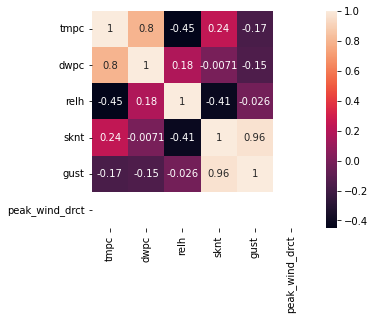

In [29]:
sns.heatmap(dataset.corr(), annot=True, square=True)

We can see as I mentioned previously, temperature and temp of dew are both highly positively correlated at 0.8, and so is wind speed and wind gust at 0.96.
Humidity (the attribute we are going to try and predict) is moderately negatively correlated with temperature and wind speed.

We can graph humdity's relationship with every other attribute to better illistrate the correlation.

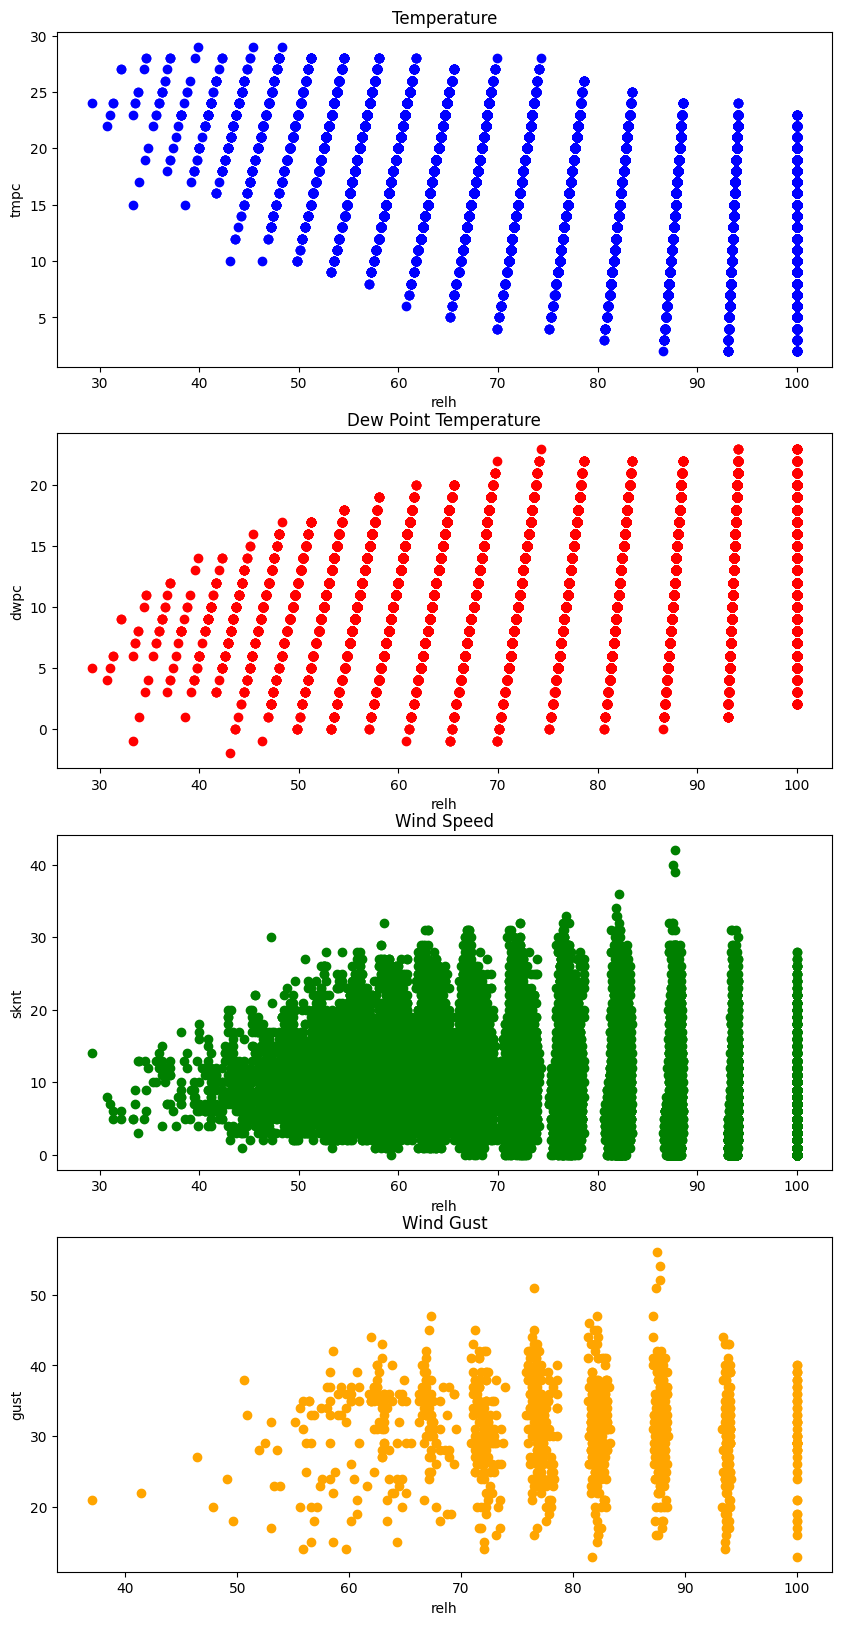

In [30]:
plt.style.use("default")
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, squeeze=True)

ax1.plot(dataset["relh"], dataset["tmpc"], 'o', color="blue")
ax1.set_title("Temperature")
ax1.set_xlabel("relh")
ax1.set_ylabel("tmpc")

ax2.plot(dataset["relh"], dataset["dwpc"], 'o', color="red")
ax2.set_title("Dew Point Temperature")
ax2.set_xlabel("relh")
ax2.set_ylabel("dwpc")

ax3.plot(dataset["relh"], dataset["sknt"], 'o', color="green")
ax3.set_title("Wind Speed")
ax3.set_xlabel("relh")
ax3.set_ylabel("sknt")

ax4.plot(dataset["relh"], dataset["gust"], 'o', color="orange")
ax4.set_title("Wind Gust")
ax4.set_xlabel("relh")
ax4.set_ylabel("gust")

fig.set_size_inches(10,20)

### Part 2 - Data Preparation

We do not need columns 0, 1, 6, and 7 so they will be removed.

Columns 0 and 1 contains strings so they are not usable, and columns 6 and 7 are mostly null-values so they are not usable either.

We also need to drop any rows with missing (NaN) values.

I will also create a new column called "index" which I will be using to predict the dataset one month after the latest date in the dataset.

In [31]:
dataset.drop(columns=["station", "valid", "gust", "peak_wind_drct"], inplace=True)
dataset = dataset.reset_index()
dataset.head()

,index,tmpc,dwpc,relh,sknt
0,0,21.0,11.0,52.77,15.0
1,1,21.0,10.0,49.37,16.0
2,2,21.0,12.0,56.38,16.0
3,3,21.0,13.0,60.21,16.0
4,4,21.0,12.0,56.38,16.0


In [32]:
dataset.info()
dataset = dataset.dropna()

# Checking that there are no NaN values left in the dataframe
dataset.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103713 entries, 0 to 103712
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   index   103713 non-null  int64  
 1   tmpc    103678 non-null  float64
 2   dwpc    103678 non-null  float64
 3   relh    103593 non-null  float64
 4   sknt    103704 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 4.0 MB


index    0
tmpc     0
dwpc     0
relh     0
sknt     0
dtype: int64

Now that there are no NaN values and non-numeric values in the dataframe we can split the data into training and testing sets.
I will also create seperate training and testings sets for prediction individual attributes using the index attribute. We will need this to predict each attributes' value one month in the future.

In [33]:
x_train, x_test, y_train, y_test = train_test_split(dataset[["index", "tmpc", "dwpc", "sknt"]], dataset["relh"], test_size=0.2)
x1_train, x1_test, y1_train, y1_test = train_test_split(dataset["index"], dataset["tmpc"], test_size=0.2)
x2_train, x2_test, y2_train, y2_test = train_test_split(dataset["index"], dataset["dwpc"], test_size=0.2)
x3_train, x3_test, y3_train, y3_test = train_test_split(dataset["index"], dataset["relh"], test_size=0.2)
x4_train, x4_test, y4_train, y4_test = train_test_split(dataset["index"], dataset["sknt"], test_size=0.2)
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82867 entries, 88476 to 102408
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   82867 non-null  int64  
 1   tmpc    82867 non-null  float64
 2   dwpc    82867 non-null  float64
 3   sknt    82867 non-null  float64
dtypes: float64(3), int64(1)
memory usage: 3.2 MB


In [34]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20717 entries, 8967 to 94140
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   20717 non-null  int64  
 1   tmpc    20717 non-null  float64
 2   dwpc    20717 non-null  float64
 3   sknt    20717 non-null  float64
dtypes: float64(3), int64(1)
memory usage: 809.3 KB


In [35]:
y_train.info()

<class 'pandas.core.series.Series'>
Int64Index: 82867 entries, 88476 to 102408
Series name: relh
Non-Null Count  Dtype  
--------------  -----  
82867 non-null  float64
dtypes: float64(1)
memory usage: 1.3 MB


In [36]:
y_test.info()

<class 'pandas.core.series.Series'>
Int64Index: 20717 entries, 8967 to 94140
Series name: relh
Non-Null Count  Dtype  
--------------  -----  
20717 non-null  float64
dtypes: float64(1)
memory usage: 323.7 KB


### Part 3 - Data Modelling

For the model, I will be using linear regression 

In [44]:
model = LinearRegression()
model.fit(x_train.values, y_train)
model.score(x_test.values, y_test)

0.9884752540345583

We can see the score for the model is extremely good, which shows linear regression was a good fit for this dataset.

Each day in the dataset represents 48 rows. If we multiply this by 31 (days) we get 1488 rows.
Meaning to predict one month in the future we need to get the index of the latest entry in the dataset and add 1488, which is: 103714 + 1448 = 105162.
To predict the humdity using the model I created, we need the index, tmpc, dwpc, and sknt, so I need to predict these values and then use those to predict the humidity.

In [45]:
one_month_ahead = np.array([105162])
one_month_ahead = one_month_ahead.reshape(-1,1)

model1 = LinearRegression()
x1_tr = np.array(x1_train)
x1_tr = x1_tr.reshape(-1,1)
model1.fit(x1_tr, y1_train)
tmpc_pred = model1.predict(one_month_ahead)
print(f"tmpc: {tmpc_pred}")

model2 = LinearRegression()
x2_tr = np.array(x2_train)
x2_tr = x2_tr.reshape(-1,1)
model2.fit(x2_tr, y2_train)
dwpc_pred = model2.predict(one_month_ahead)
print(f"dwpc: {dwpc_pred}")

# This prediction will not be used for the final model, just doing it for testing.
model3 = LinearRegression()
x3_tr = np.array(x3_train)
x3_tr = x3_tr.reshape(-1,1)
model3.fit(x3_tr, y3_train)
relh_pred = model3.predict(one_month_ahead)
print(f"relh: {relh_pred}")

model4 = LinearRegression()
x4_tr = np.array(x4_train)
x4_tr = x4_tr.reshape(-1,1)
model4.fit(x4_tr, y4_train)
sknt_pred = model4.predict(one_month_ahead)
print(f"sknt: {sknt_pred}")

prediction = model.predict(np.array([[one_month_ahead[0][0], tmpc_pred[0], dwpc_pred[0], sknt_pred[0]]]))

print(f"Prediction for 1 month in the future: {prediction}")

tmpc: [15.48999257]
dwpc: [11.71435934]
relh: [79.50070962]
sknt: [9.13853939]
Prediction for 1 month in the future: [79.35831797]


### Results


The model predicts that in roughly one month the humdity will be 79.35.

The model I trained was very accurate, however using the dataset to predict one month ahead was difficult. As the dataset contains so many entries (103714 rows), I felt that using the index as an attribute to measure time was not very effective. We can demonstrate how correlated the attributes were to the index by creating a heatmap.

<AxesSubplot:>

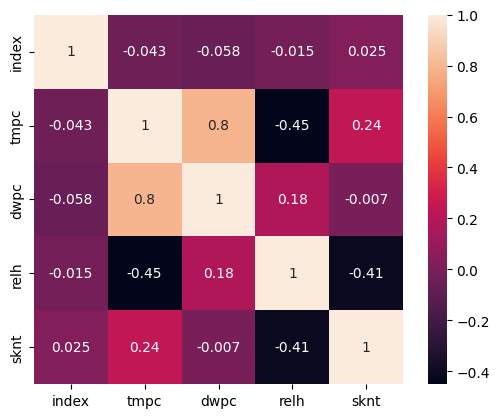

In [46]:
sns.heatmap(dataset.corr(), annot=True, square=True)

We can see that the index is almost not correlated with the other attributes at all. We can show how the attributes look over time by plotting them against the index:

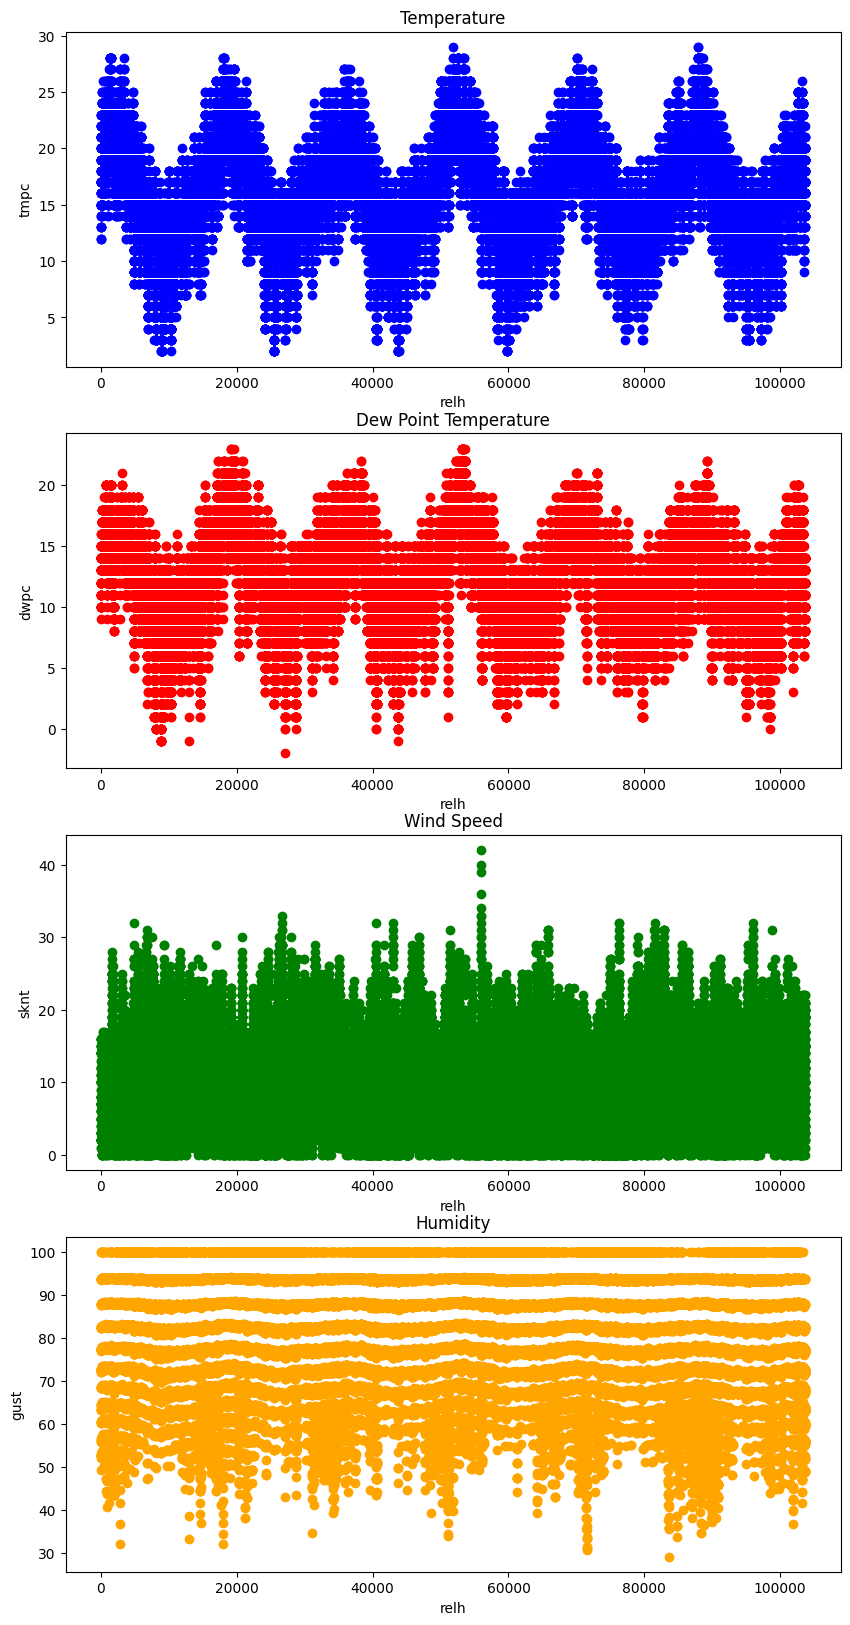

In [48]:
plt.style.use("default")
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, squeeze=True)

ax1.plot(dataset["index"], dataset["tmpc"], 'o', color="blue")
ax1.set_title("Temperature")
ax1.set_xlabel("relh")
ax1.set_ylabel("tmpc")

ax2.plot(dataset["index"], dataset["dwpc"], 'o', color="red")
ax2.set_title("Dew Point Temperature")
ax2.set_xlabel("relh")
ax2.set_ylabel("dwpc")

ax3.plot(dataset["index"], dataset["sknt"], 'o', color="green")
ax3.set_title("Wind Speed")
ax3.set_xlabel("relh")
ax3.set_ylabel("sknt")

ax4.plot(dataset["index"], dataset["relh"], 'o', color="orange")
ax4.set_title("Humidity")
ax4.set_xlabel("relh")
ax4.set_ylabel("gust")

fig.set_size_inches(10,20)

As we can see, It is very difficult to draw a regression line for these attributes as their values seem to alternate up and down like a wave. Which explains why it using the index to draw a correlation was not effective.
The prediction was probably accurate given the values however the way I obtained these values was not optimal. Not the mention the index value goes up to 103,714 which heavily inflates the value compared to the other attributes as the highest they go is up to 100. This did not seem to affect the model very much but still unoptimal. If I had more time, I would have liked to investigate better ways to measure the time for this dataset.